# 인물 모드 사진 만들기 
## Step 1) 인물 모드
- 최소 3장 이상의 인물모드 사진 만들기
- 인물, 고양이 등 아웃포커싱 사진 만들기
- 배경을 blur 모드가 아닌, 다른 이미지로 교체(크로마키 배경합성) 시도하기  

### 1. 인물 모드 사진

In [1]:
# 모듈 준비
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib    #웹에서 데이터 다운로드 받을 때 사용

from matplotlib import pyplot as plt
import tensorflow as tf

(776, 796, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

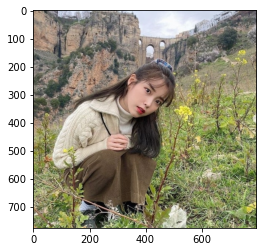

In [2]:
# 이미지 읽기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/iu.jpg' # 이미지 선택
img_person = cv2.imread(img_path)
print(img_person.shape)

img_rgb = cv2.cvtColor(img_person, cv2.COLOR_BGR2RGB) #이미지 나타내기
plt.imshow(img_rgb)
plt.show

In [35]:
# Segmantic segmentation - DeepLab Model 이용

class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        #모델이 받는 입력 크기가 정해져있으므로 적절한 크기로 resize
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        # OpenCV의 디폴트 BGR 채널 순서를 텐서플로우에 맞는 RGB로 수정
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image): #세그멘테이션 하는 함수
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [36]:
# 사전에 학습된 가중치 불러오기 (구글 제공 파일 다운)
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [37]:
# 준비한 이미지를 네트워크에 입력한다.
img_resized, seg_map = MODEL.run(img_person)
print(img_person.shape, img_resized.shape, seg_map.max())
# 원래 이미지 사이즈, resize된 이미지 사이즈, 15번은 사람 이미지 라벨

(776, 796, 3) (500, 513, 3) 15


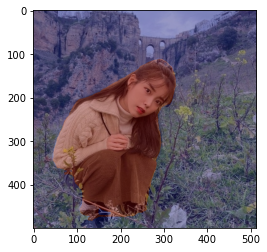

In [38]:
# person(사람) 라벨 = 15 영역만 검출하고 싶다.
# 마스크 (세그멘테이션 결과) 만들기
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

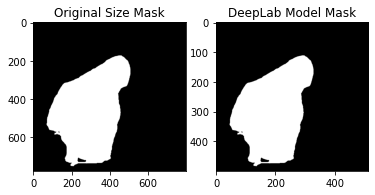

In [39]:
# 세그멘테이션 결과(mask)를 원래 크기로 복원
img_mask_up = cv2.resize(img_mask, img_person.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

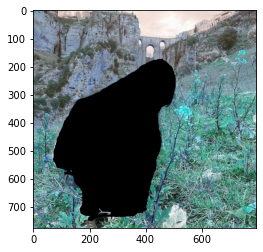

In [40]:
# 배경 흐리게 하기
# segmentation mask를 이용해 배경만 추출
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_person, img_bg_mask)
plt.imshow(img_bg)
plt.show()

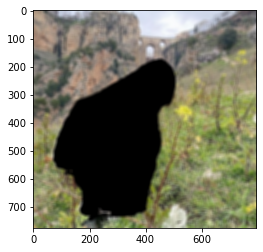

In [42]:
# 이미지 블러(blur)처리
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

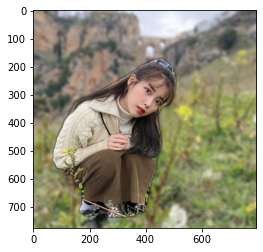

In [43]:
# 흐린 배경과 원본 영상 합성
img_concat = np.where(img_mask_color==255, img_person, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()



### 2. 고양이 Ver.

(1064, 1300, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

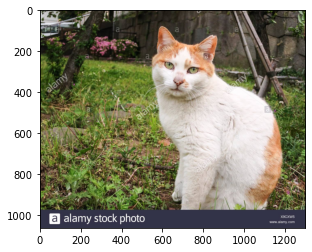

In [63]:
img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpg' 
img_cat = cv2.imread(img_path2) 
print (img_cat.shape)

img_rgb2 = cv2.cvtColor(img_cat, cv2.COLOR_BGR2RGB) #이미지 나타내기
plt.imshow(img_rgb2)
plt.show

In [102]:
# 모델 이미 다운로드 받았으므로 pass


# 준비한 이미지를 네트워크에 입력
img_resized_cat, seg_map_cat = MODEL.run(img_cat)
print (img_cat.shape, img_resized_cat.shape, seg_map_cat.max()) #label 8 = cat

(1064, 1300, 3) (419, 513, 3) 8


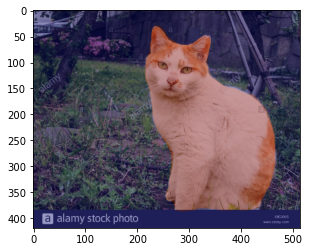

In [103]:
# cat(고양이) 라벨 = 8 영역만 검출하고 싶다.
# 마스크 (세그멘테이션 결과) 만들기

img_show_cat = img_resized_cat.copy()
seg_map_cat = np.where(seg_map_cat == 8, 8, 0) # 예측 중 고양이만 추출
img_mask_cat = seg_map_cat * (255/seg_map_cat.max()) # 255 normalization
img_mask_cat = img_mask_cat.astype(np.uint8)
color_mask_cat = cv2.applyColorMap(img_mask_cat, cv2.COLORMAP_JET)
img_show_cat = cv2.addWeighted(img_show_cat, 0.6, color_mask_cat, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show_cat, cv2.COLOR_BGR2RGB))
plt.show()

In [104]:
# 세그멘테이션 결과(mask)를 원래 크기로 복원
img_mask_up_cat = cv2.resize(img_mask_cat, img_cat.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up_cat = cv2.threshold(img_mask_up_cat, 128, 255, cv2.THRESH_BINARY)

# segmentation mask를 이용해 배경만 추출
img_mask_color_cat = cv2.cvtColor(img_mask_up_cat, cv2.COLOR_GRAY2BGR)
img_bg_mask_cat = cv2.bitwise_not(img_mask_color_cat)
img_bg_cat = cv2.bitwise_and(img_cat, img_bg_mask_cat)

# 배경 이미지 블러(blur)처리
img_bg_blur_cat = cv2.blur(img_bg_cat, (13,13))

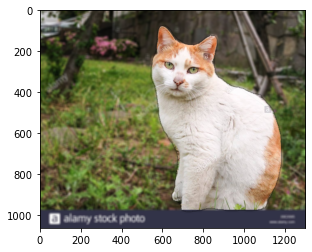

In [105]:
# 흐린 배경과 원본 영상 합성
img_concat_cat = np.where(img_mask_color_cat==255, img_cat, img_bg_blur_cat)
plt.imshow(cv2.cvtColor(img_concat_cat, cv2.COLOR_BGR2RGB))
plt.show()

### 3) 배경 크로마키 도전!
- 처음 불러온 인물 사진 이용 - 이미 있으니 생략

In [135]:
background_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/back.jpg'
background_img_orig = cv2.imread(background_img_path)
print(bacground_img_orig.shape)

(183, 275, 3)


In [136]:
# 배경 사이즈 맞춰주기
background_img_resize = cv2.resize(background_img_orig,img_person.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

print(background_img_resize.shape)

(776, 796, 3)


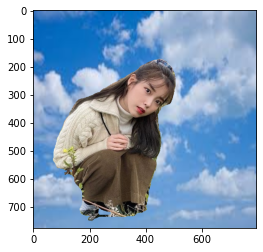

In [137]:
img_background_concat = np.where(
    img_mask_color == 255, img_person, background_img_resize)

plt.imshow(cv2.cvtColor(img_background_concat, cv2.COLOR_BGR2RGB))
plt.show()

## Step2 ) 사진에서 문제점 찾기